<a href="https://colab.research.google.com/github/babak3548/Howsam/blob/main/1_train_eval_gen_general_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  <font color='#FFE15D'><b>💎 Train, Evaluate, and Generat Functions (General) </b></font>

# 🔴 **Environment Setup**

## 🟠 Change the font size of the output cells

In [ ]:
print('Salam Howsam!')

Salam Howsam!


In [ ]:
from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(HTML('''<style>
    body {
      font-size: 24px;
    }
  '''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)

In [ ]:
print('Salam Howsam!')

Salam Howsam!


## 🟠 `pip`

In [ ]:
# !pip install -q datasets torchmetrics

# 🔴 **Import**

In [ ]:
import time
import math
import random
from tqdm import tqdm
from dataclasses import dataclass

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from datasets import load_dataset
from tokenizers import Tokenizer

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import functional as F

from torchmetrics.aggregation import MeanMetric

# 🔴 **Utils**

In [ ]:
def prepare_data(tokens, seq_len):
    # Trim tokens so that total length is divisible by seq_len
    n_tokens = (tokens.shape[0] // seq_len) * seq_len
    tokens = tokens[:n_tokens]
    # Reshape to 2D tensor
    return tokens.view(-1, seq_len)

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [ ]:
# Benchmarking function
def calculate_time(model, x, num_runs=10):
    torch.cuda.synchronize()
    start = time.time()
    for _ in range(num_runs):
        model(x)
    torch.cuda.synchronize()
    return (time.time() - start) / num_runs

# 🔴 **Init**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# 🔴 **Dataset**

In [ ]:
dataset = load_dataset("roneneldan/TinyStories")
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 2119719
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 21990
    })
})

In [ ]:
tokenizer = Tokenizer.from_file("bpe-tokenizer_tinystories.json")
tokenizer

In [ ]:
# Load tokens from pytorch file
train_token_ids = torch.load('tokenized-train-samples_vocab-10k.pt')
valid_token_ids = torch.load('tokenized-valid-samples_vocab-10k.pt')

print("📊 Number of Tokens")
print(f"🔹 Train: {len(train_token_ids):,} tokens")
print(f"🔹 Valid: {len(valid_token_ids):,} tokens")

📊 Number of Tokens
🔹 Train: 464,965,814 tokens
🔹 Valid: 4,673,588 tokens


In [ ]:
class TinyStoriesDataset(Dataset):

    def __init__(self, data, seq_len):
        self.seq_len = seq_len
        self.data = prepare_data(data, seq_len+1)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        sample = self.data[idx]
        return sample.long()#[:-1], sample[1:]

# 🔴 **Model**

## 🟠 Multi Head Attention

In [ ]:
class MultiHeadAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.n_embd = config.n_embd
        self.n_head = config.n_head
        self.head_size = self.n_embd // self.n_head

        self.qkv_proj = nn.Linear(self.n_embd, 3*self.n_embd, bias=False)
        self.c_proj = nn.Linear(self.n_embd, self.n_embd, bias=False)
        self.c_proj.residual = True

    def forward(self, x):
        B, T, C = x.shape
        # QKV linear
        q, k, v = self.qkv_proj(x).view(B, T, 3*self.n_head, self.head_size).transpose(1, 2).chunk(3, dim=-3)
        # Scaled Dot Product Attention using pytorch
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True)
        # Reshape and final projection
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.c_proj(y)
        return y

## 🟠 Feed Forward (MLP)

In [ ]:
class FeedForward(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.n_embd = config.n_embd
        self.f_expnd = config.f_expnd

        self.up_proj = nn.Linear(self.n_embd, int(self.f_expnd*self.n_embd), bias=False)
        self.down_proj = nn.Linear(int(self.f_expnd*self.n_embd), self.n_embd, bias=False)
        self.down_proj.residual = True

    def forward(self, x):
        return self.down_proj(F.gelu(self.up_proj(x)))

## 🟠 Decoder Block

In [ ]:
class DecoderBlock(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.n_embd = config.n_embd
        # Multi Head Attention
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.mha = MultiHeadAttention(config)
        # Feed Forward Neural Network
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.mlp = FeedForward(config)

    def forward(self, x):
        x = x + self.mha(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

## 🟠 GPT

In [ ]:
class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.wte = nn.Embedding(config.vocab_size, config.n_embd) # Token embedding
        self.wpe = nn.Embedding(config.max_seq_len, config.n_embd) # Position embedding
        self.decoders = nn.ModuleList([DecoderBlock(config) for _ in range(config.n_layer)]) # Decoders
        self.lnf = nn.LayerNorm(config.n_embd)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False) # Classifier
        self.lm_head.weight = self.wte.weight # Weight tying

        self.apply(self._init_weights)

    def _init_weights(self, module):
        std = 0.02
        if isinstance(module, nn.Linear):
            if hasattr(module, 'residual'):
                std *= (2*self.config.n_layer)**-0.5
            nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=std)

    def forward(self, idx):
        B, T = idx.shape
        # Token Embedding + Position Embedding
        x = self.wte(idx) + self.wpe(torch.arange(T, device=device))
        # Decoders
        for decoder in self.decoders:
            x = decoder(x)
        # Classifier
        x = self.lnf(x)
        logits = self.lm_head(x)
        return logits

## 🟠 Config

In [ ]:
@dataclass
class GPTConfig:
    vocab_size: int = 50257 # number of tokens
    max_seq_len: int = 1024 # max sequence length
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension
    f_expnd: int = 4 # expansion factor in mlp

# 🔴 **Functions ⚙️**

## 🟠 Train ➰

In [ ]:
def train_one_epoch(model, train_loader, optimizer, epoch=None):
    model.train()
    loss_train = MeanMetric()

    with tqdm(train_loader, unit='batch') as tepoch:
        for inputs in tepoch:
            if epoch is not None:
                tepoch.set_description(f'Epoch {epoch}')

            inputs = inputs.to(device)
            logits = model(inputs[:, :-1])
            loss = F.cross_entropy(logits.reshape(-1, logits.shape[-1]), inputs[:, 1:].flatten())
            loss.backward()

            nn.utils.clip_grad.clip_grad_norm_(model.parameters(), max_norm=1.)

            optimizer.step()
            optimizer.zero_grad()

            loss_train.update(loss.item(), inputs.shape[0])

            tepoch.set_postfix(loss=loss_train.compute().item())

    return loss_train.compute().item()

## 🟠 Evaluate

In [ ]:
def evaluate(model, valid_loader):
    model.eval()
    loss_eval = MeanMetric()

    with torch.inference_mode():
        for inputs in valid_loader:
            inputs = inputs.to(device)

            logits = model(inputs[:, :-1])

            loss = F.cross_entropy(logits.reshape(-1, logits.shape[-1]), inputs[:, 1:].flatten())
            loss_eval.update(loss.item(), inputs.shape[0])

    return loss_eval.compute().item()

## 🟠 Generate

In [ ]:
def generate_text(
        model, tokenizer, xgen, max_length, temperature=1.0, top_k=50, num_return_sequences=1, device='cpu', seed=42):
    """
    Generates text using top-k sampling.

    Args:
        model: The language model.
        tokenizer: Tokenizer for decoding generated text.
        xgen: Initial token sequence (Tensor of shape (B, T)).
        max_length: Maximum length of generated text.
        temperature: Sampling temperature.
        top_k: Number of top candidates to sample from.
        num_return_sequences: Number of generated sequences.
        device: Device to run the model on.
        seed: Random seed for reproducibility.
        epoch: Current epoch number (for logging).
    """
    # Initialize a random number generator for sampling
    sample_rng = torch.Generator(device=device)
    sample_rng.manual_seed(seed)

    generated_texts = []

    with torch.no_grad():  # Move outside the loop to optimize performance
        while xgen.size(1) < max_length:
            logits = model(xgen)  # (B, T, vocab_size)
            logits = logits[:, -1, :]  # Take the logits at the last position (B, vocab_size)
            probs = F.softmax(logits / temperature, dim=-1)  # Get the probabilities

            # Perform top-k sampling (default k=50 in Hugging Face pipeline)
            topk_probs, topk_indices = torch.topk(probs, top_k, dim=-1)  # (B, top_k)

            # Select a token from the top-k probabilities
            # Note: multinomial does not require the input to sum to 1
            ix = torch.multinomial(topk_probs, 1, generator=sample_rng)  # (B, 1)

            # Gather the corresponding indices from the top-k indices
            xcol = torch.gather(topk_indices, -1, ix)  # (B, 1)

            # Append the selected token to the sequence
            xgen = torch.cat((xgen, xcol), dim=1)

    # Decode and return generated sequences
    for i in range(num_return_sequences):
        tokens = xgen[i, :max_length].tolist()
        decoded_text = tokenizer.decode(tokens)
        generated_texts.append(decoded_text)

    return generated_texts  # Return generated sequences as a list

# 🔴 **Training Process 〽️**

In [ ]:
torch.manual_seed(1337)

seq_len = 128
train_set = TinyStoriesDataset(train_token_ids, seq_len)
valid_set = TinyStoriesDataset(valid_token_ids, seq_len)

batch_size = 192
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)#, num_workers=4)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, pin_memory=True)#, num_workers=4)

print(f"📊 Number of Batches")
print(f"🔹 Train: {len(train_loader):,} batches")
print(f"🔹 Valid: {len(valid_loader):,} batches")

📊 Number of Batches
🔹 Train: 18,773 batches
🔹 Valid: 189 batches


In [ ]:
model = GPT(
    GPTConfig(
        max_seq_len=256,
        vocab_size=10_000,
        n_embd=128,
        n_layer=8,
        n_head=16
        )
    ).to(device)

print(model)
num_trainable_params(model)

GPT(
  (wte): Embedding(10000, 128)
  (wpe): Embedding(256, 128)
  (decoders): ModuleList(
    (0-7): 8 x DecoderBlock(
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mha): MultiHeadAttention(
        (qkv_proj): Linear(in_features=128, out_features=384, bias=False)
        (c_proj): Linear(in_features=128, out_features=128, bias=False)
      )
      (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mlp): FeedForward(
        (up_proj): Linear(in_features=128, out_features=512, bias=False)
        (down_proj): Linear(in_features=512, out_features=128, bias=False)
      )
    )
  )
  (lnf): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (lm_head): Linear(in_features=128, out_features=10000, bias=False)
)


2.889984

In [ ]:
learning_rate = 6e-4
weight_decay = 0.1
use_fused = True

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    betas=(0.9, 0.95),
    weight_decay=weight_decay,
    fused=use_fused
    )

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
prompts = [
    'In last night',
    'Once upon',
    'Once upon a time',
    'One day, a little boy named TimTommy was a smart 3 year old, much smarter']

num_return_sequences = 3
sent_test = [
    torch.tensor(tokens.ids, dtype=torch.long).unsqueeze(0).repeat(num_return_sequences, 1).to(device)
    for tokens in tokenizer.encode_batch(prompts)]
sent_test

temperature = 0.9
max_length = 32
top_k = 50

In [ ]:
torch.manual_seed(1337)
num_epochs = 2

for epoch in range(0, num_epochs+1):
    # Train
    loss_train = train_one_epoch(model, train_loader, optimizer, epoch)

    # Validation
    loss_valid = evaluate(model, valid_loader)
    print(f'Valid: Loss = {loss_valid:.4}')

    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)

    if loss_valid < best_loss_valid:
        torch.save(model, f'best-model.pt')
        best_loss_valid = loss_valid
        print(f'Model Saved!')
    print(150*'.')

    # Generate
    if epoch % 3 == 0 or epoch == num_epochs:
        model.eval()
        for xgen in sent_test:
            xgen = generate_text(model, tokenizer, xgen, max_length, temperature, 50, 3, device)
            for i, text in enumerate(xgen):
                print(f"Epoch {epoch} Sample {i}: {text}")
            print(150*'.')

    epoch_counter += 1

Epoch 0:   0%|                                                                            | 0/18773 [00:00<?, ?batch/s]C:\Users\Howsam\AppData\Local\Temp\ipykernel_12048\2308121339.py:18: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  y = F.scaled_dot_product_attention(q, k, v, is_causal=True)
Epoch 0: 100%|█████████████████████████████████████████████████████| 18773/18773 [50:12<00:00,  6.23batch/s, loss=2.17]


Valid: Loss = 1.98
Model Saved!
......................................................................................................................................................
Epoch 0 Sample 0: In last night, the birds were so surprised that the big cloud was now gone. All its friends looked around the big, scary cloud in the clouds.
Epoch 0 Sample 1: In last night, they were dreaming of their friends. They liked to hear them laugh and laugh. One night, they heard a loud noise. It sounded
Epoch 0 Sample 2: In last night, the princess and her princess were standing in the sun. But when the sun went down, the princess was still asleep.

The
......................................................................................................................................................
Epoch 0 Sample 0: Once upon a time, there were two friends, Lily and Sam. They loved to play together in the snow. One day, they found a big,
Epoch 0 Sample 1: Once upon a time, there was a girl 

Epoch 1: 100%|███████████████████████████████████████████████████| 18773/18773 [1:15:36<00:00,  4.14batch/s, loss=1.95]


Valid: Loss = 1.942
Model Saved!
......................................................................................................................................................


Epoch 2: 100%|█████████████████████████████████████████████████████| 18773/18773 [49:51<00:00,  6.28batch/s, loss=1.93]


Valid: Loss = 1.925
Model Saved!
......................................................................................................................................................
Epoch 2 Sample 0: In last night, a little girl was going to take a nap. She lay down in her bed, closed her eyes, and snuggled up in her bed
Epoch 2 Sample 1: In last night, something special happened. The sky lit up in amazing happened and a few people started their day to fall asleep. Suddenly, a loud crash
Epoch 2 Sample 2: In last night, a chubby boy named Tim went to bed up in his beds with a big smile on his face. He was happy and ready to sleep
......................................................................................................................................................
Epoch 2 Sample 0: Once upon a time, there were two friends, Fred and Bob. Fred had a new toy. It was a bright red balloon, and Bob wanted to
Epoch 2 Sample 1: Once upon a time, there was a girl named Lily. She

In [ ]:
torch.cuda.empty_cache()

## 🟠 Learning Curves

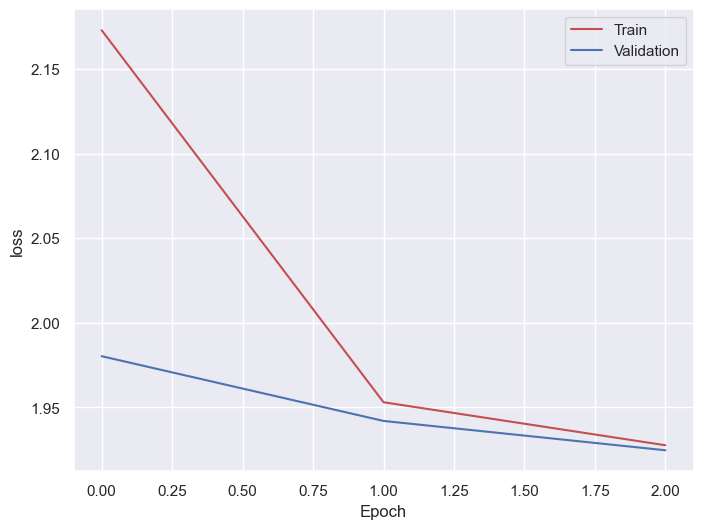

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(range(len(loss_train_hist)), loss_train_hist, 'r-', label='Train')
plt.plot(range(len(loss_valid_hist)), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend();